# Hymba Ablation Study

## 내 구현 vs 공식 구현 스타일 비교 (arXiv:2411.13676)

이 노트북은 **내 구현**과 **공식 구현 스타일**의 Hymba 모델을 비교하여 논문의 핵심 주장을 검증합니다.

### 구현 비교

| 구성요소 | 내 구현 | 공식 구현 스타일 |
|----------|---------|------------------|
| **Projection** | 분리된 Q, K, V projection | 단일 in_proj (모든 것 포함) |
| **Fusion** | β_attn * norm(A) + β_mamba * norm(M) | **(norm(A) + norm(M)) / 2** |
| **KV Sharing** | Producer-Consumer 패턴 | Producer-Consumer 패턴 |
| **Attention** | FlexAttention / Standard | Standard attention |
| **SWA Mask** | causal AND (window OR meta) | causal AND (window OR meta) |

### Sliding Window Attention (SWA)

```
SWA 마스크 조건 (Local 레이어):
1. Causal: k <= q (과거만 attend)
2. Window: k >= q - window + 1 (윈도우 내)
3. Meta: k < num_meta (meta 토큰은 항상 attend 가능)

최종: causal AND (in_window OR is_meta)
```

### KV Sharing (Producer-Consumer 패턴)

```
공식 config (Hymba-1.5B-Base):
"kv_reuse_group": [[1,2], [3,4], [5,6], ..., [29,30]]
```

- **Producer 레이어** (1, 3, 5, ...): K, V projection 수행
- **Consumer 레이어** (2, 4, 6, ...): **Q만 계산**, K/V는 producer에서 재사용
- Global 레이어 (0, 15, 31)는 KV 공유에서 제외

### 실험 목표

1. **아키텍처 비교**: Mamba-only vs Transformer-only vs Hybrid
2. **구현 비교**: 내 구현 vs 공식 구현 스타일
3. **컴포넌트별 기여도**: Meta Tokens, KV Sharing, SWA
4. **학습 안정성**: Loss 수렴 비교

In [1]:
import sys
import os
import warnings
sys.path.append('./backbone')

os.environ['TOKENIZERS_PARALLELISM'] = 'false'
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time
from tqdm.auto import tqdm
from dataclasses import dataclass
from typing import Dict, List, Optional

# 모듈 리로드
import importlib
if 'hymba' in sys.modules:
    importlib.reload(sys.modules['hymba'])
if 'hymba_official' in sys.modules:
    importlib.reload(sys.modules['hymba_official'])

# 내 구현
from hymba import Hymba, HymbaConfig, ArchType, AttentionType

# 공식 구현 스타일
from hymba_official import HymbaOfficialModel, HymbaOfficialConfig

from datasets import load_dataset
from torch.utils.data import DataLoader, TensorDataset, random_split

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import ByteLevel
from tokenizers.processors import ByteLevel as ByteLevelProcessor

RESULTS_DIR = './results'
os.makedirs(RESULTS_DIR, exist_ok=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')
if device == 'cuda':
    print(f'GPU: {torch.cuda.get_device_name()}')

plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['figure.dpi'] = 150
sns.set_style('whitegrid')

torch.manual_seed(42)
np.random.seed(42)

Device: cuda
GPU: NVIDIA A100 80GB PCIe


---

## 1. 데이터 준비

In [2]:
print('=' * 60)
print('데이터셋 로드: Tiny Shakespeare')
print('=' * 60)

ds = load_dataset('karpathy/tiny_shakespeare')
text = '\n\n'.join(ds['train']['text'])

print(f'텍스트 길이: {len(text):,} 문자')
print(f'샘플:\n{text[:300]}...')

데이터셋 로드: Tiny Shakespeare
텍스트 길이: 1,003,854 문자
샘플:
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us...


In [3]:
VOCAB_SIZE = 4096

print('BPE 토크나이저 학습 중...')
tokenizer_bpe = Tokenizer(BPE(unk_token='<unk>'))
tokenizer_bpe.pre_tokenizer = ByteLevel(add_prefix_space=False)
tokenizer_bpe.post_processor = ByteLevelProcessor(trim_offsets=False)

trainer = BpeTrainer(
    vocab_size=VOCAB_SIZE,
    special_tokens=['<unk>', '<pad>', '<bos>', '<eos>'],
    min_frequency=2,
)
tokenizer_bpe.train_from_iterator([text], trainer=trainer)

class TokenizerWrapper:
    def __init__(self, tk):
        self._tk = tk
        self._vocab_size = tk.get_vocab_size()
    
    def encode(self, text: str) -> List[int]:
        return self._tk.encode(text).ids
    
    def decode(self, ids: List[int]) -> str:
        return self._tk.decode(ids)
    
    @property
    def vocab_size(self) -> int:
        return self._vocab_size

tokenizer = TokenizerWrapper(tokenizer_bpe)
print(f'어휘 크기: {tokenizer.vocab_size:,}')

BPE 토크나이저 학습 중...



어휘 크기: 4,096


In [4]:
SEQ_LEN = 256
BATCH_SIZE = 16
TRAIN_RATIO = 0.9

def create_dataset(tokenizer, text: str, seq_len: int) -> TensorDataset:
    ids = np.array(tokenizer.encode(text), dtype=np.int64)
    x, y = ids[:-1], ids[1:]
    n_samples = len(y) // seq_len
    n = n_samples * seq_len
    X = torch.tensor(x[:n].reshape(n_samples, seq_len))
    Y = torch.tensor(y[:n].reshape(n_samples, seq_len))
    return TensorDataset(X, Y)

full_dataset = create_dataset(tokenizer, text, SEQ_LEN)
train_size = int(TRAIN_RATIO * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f'학습: {len(train_dataset):,} 샘플, {len(train_loader):,} 배치')
print(f'검증: {len(val_dataset):,} 샘플')

학습: 1,074 샘플, 67 배치
검증: 120 샘플


---

## 2. 실험 설정

### 핵심 제약 조건 (공식 구현 기반)

1. **Local attention 레이어는 2의 배수**: KV sharing을 위해 연속 2개가 쌍(producer-consumer)을 이룸
2. **Global attention**: 첫/중간/마지막 레이어만
3. **Mamba**: 레이어당 1개만 (num_mamba=1)

In [5]:
@dataclass
class ExperimentConfig:
    name: str
    config: any  # HymbaConfig or HymbaOfficialConfig
    description: str
    is_official: bool = False  # 공식 구현 여부

# 모든 모델을 ~20M 파라미터 수준으로 맞춤
experiments: Dict[str, ExperimentConfig] = {
    # ===================== 내 구현 =====================
    # 1. Mamba-only baseline (~19M)
    'Mamba-only': ExperimentConfig(
        name='Mamba-only',
        config=HymbaConfig(
            vocab_size=tokenizer.vocab_size,
            d_model=384,
            n_layers=8,
            n_heads=6,
            n_kv_heads=2,
            arch_type=ArchType.MAMBA_ONLY,
            use_meta_tokens=False,
            swa_window=128,
            dropout=0.1,
        ),
        description='순수 Mamba SSM',
        is_official=False,
    ),
    
    # 2. Transformer-only baseline (~20M)
    'Transformer-only': ExperimentConfig(
        name='Transformer-only',
        config=HymbaConfig(
            vocab_size=tokenizer.vocab_size,
            d_model=384,
            n_layers=12,
            n_heads=6,
            n_kv_heads=2,
            arch_type=ArchType.TRANSFORMER_ONLY,
            global_attn_idx=list(range(12)),  # 모두 Global
            use_meta_tokens=False,
            swa_window=128,
            dropout=0.1,
        ),
        description='순수 Transformer',
        is_official=False,
    ),
    
    # 3. Hybrid (내 구현) (~21M)
    # 11 layers: global=[0,5,10] -> local=[1,2,3,4,6,7,8,9] = 8개 (짝수) OK!
    'Hybrid-Mine': ExperimentConfig(
        name='Hybrid-Mine',
        config=HymbaConfig(
            vocab_size=tokenizer.vocab_size,
            d_model=320,
            n_layers=11,
            n_heads=5,
            n_kv_heads=1,
            arch_type=ArchType.HYBRID,
            global_attn_idx=[0, 5, 10],  # 첫/중간/마지막 -> Local: 8개
            use_meta_tokens=True,
            num_meta_tokens=64,
            swa_window=128,
            dropout=0.1,
        ),
        description='Hybrid (내 구현: Attn+Mamba, KV sharing, Meta tokens)',
        is_official=False,
    ),
    
    # 4. Hybrid without Meta Tokens (ablation) (~21M)
    'Hybrid-NoMeta': ExperimentConfig(
        name='Hybrid-NoMeta',
        config=HymbaConfig(
            vocab_size=tokenizer.vocab_size,
            d_model=320,
            n_layers=11,
            n_heads=5,
            n_kv_heads=1,
            arch_type=ArchType.HYBRID,
            global_attn_idx=[0, 5, 10],
            use_meta_tokens=False,
            swa_window=128,
            dropout=0.1,
        ),
        description='Hybrid without Meta Tokens',
        is_official=False,
    ),
    
    # ===================== 공식 구현 스타일 =====================
    # 5. Hybrid (공식 구현 스타일) (~22M)
    'Hybrid-Official': ExperimentConfig(
        name='Hybrid-Official',
        config=HymbaOfficialConfig(
            vocab_size=tokenizer.vocab_size,
            hidden_size=320,
            num_hidden_layers=11,
            num_attention_heads=5,
            num_key_value_heads=1,
            attn_hidden_size=320,
            global_attn_idx=[0, 5, 10],  # 첫/중간/마지막
            num_memory_tokens=64,
            attn_window_size=128,  # SWA window
            mamba_expand=2,
            mamba_d_state=16,
            mamba_d_conv=4,
            intermediate_size=320 * 3,  # FFN
            attention_dropout=0.1,
        ),
        description='Hybrid (공식 스타일: 단일 in_proj, avg fusion)',
        is_official=True,
    ),
    
    # 6. 공식 스타일 - Meta Tokens 없이 (~22M)
    'Official-NoMeta': ExperimentConfig(
        name='Official-NoMeta',
        config=HymbaOfficialConfig(
            vocab_size=tokenizer.vocab_size,
            hidden_size=320,
            num_hidden_layers=11,
            num_attention_heads=5,
            num_key_value_heads=1,
            attn_hidden_size=320,
            global_attn_idx=[0, 5, 10],
            num_memory_tokens=0,  # Meta tokens 없음
            attn_window_size=128,
            mamba_expand=2,
            mamba_d_state=16,
            mamba_d_conv=4,
            intermediate_size=320 * 3,
            attention_dropout=0.1,
        ),
        description='공식 스타일 without Meta Tokens',
        is_official=True,
    ),
}

# 실험 정보 출력
print('=' * 100)
print('실험 설정 (모델 크기 ~20M 수준으로 통일)')
print('=' * 100)
print(f'{"Name":<20} {"Impl":>8} {"Params":>10} {"Layers":>7} {"Meta":>6} {"SWA":>6}')
print('-' * 100)

for name, exp in experiments.items():
    cfg = exp.config
    impl = 'Official' if exp.is_official else 'Mine'
    
    if exp.is_official:
        model = HymbaOfficialModel(cfg)
        params = model.count_parameters()['total']
        meta = cfg.num_memory_tokens
        swa = cfg.attn_window_size
        layers = cfg.num_hidden_layers
    else:
        model = Hymba(cfg)
        params = model.count_parameters()['total']
        meta = cfg.num_meta_tokens if cfg.use_meta_tokens else 0
        swa = cfg.swa_window
        layers = cfg.n_layers
    
    print(f'{name:<20} {impl:>8} {params/1e6:>9.2f}M {layers:>7} {meta:>6} {swa:>6}')
    del model
    torch.cuda.empty_cache()

print('=' * 100)

실험 설정 (모델 크기 ~20M 수준으로 통일)
Name                     Impl     Params  Layers   Meta    SWA
----------------------------------------------------------------------------------------------------
Mamba-only               Mine     18.73M       8      0    128
Transformer-only         Mine     20.46M      12      0    128
Hybrid-Mine              Mine     20.33M      11     64    128
Hybrid-NoMeta            Mine     20.31M      11      0    128
Hybrid-Official      Official     21.63M      11     64    128
Official-NoMeta      Official     21.61M      11      0    128


---

## 3. 학습

In [6]:
@dataclass
class TrainConfig:
    epochs: int = 25
    lr: float = 3e-4
    warmup_steps: int = 100
    weight_decay: float = 0.1
    grad_clip: float = 1.0
    label_smoothing: float = 0.1
    eval_interval: int = 50

def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    config: TrainConfig,
    model_name: str = '',
):
    model = model.to(device).train()
    
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config.lr,
        betas=(0.9, 0.99),
        weight_decay=config.weight_decay,
    )
    
    total_steps = config.epochs * len(train_loader)
    
    def lr_lambda(step):
        if step < config.warmup_steps:
            return step / config.warmup_steps
        progress = (step - config.warmup_steps) / max(1, total_steps - config.warmup_steps)
        return 0.1 + 0.9 * 0.5 * (1 + np.cos(np.pi * progress))
    
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    
    history = {'train_loss': [], 'val_loss': [], 'val_ppl': [], 'step': []}
    step = 0
    best_val_loss = float('inf')
    t0 = time.time()
    
    for epoch in range(config.epochs):
        model.train()
        pbar = tqdm(train_loader, desc=f'[{model_name}] Epoch {epoch+1}/{config.epochs}', leave=False)
        
        for xb, yb in pbar:
            xb, yb = xb.to(device), yb.to(device)
            
            out = model(xb, targets=yb)
            logits = out['logits']
            loss = F.cross_entropy(
                logits.reshape(-1, logits.size(-1)),
                yb.reshape(-1),
                label_smoothing=config.label_smoothing
            )
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_clip)
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()
            step += 1
            
            if step % config.eval_interval == 0:
                model.eval()
                val_loss = 0.0
                val_tokens = 0
                
                with torch.no_grad():
                    for vxb, vyb in val_loader:
                        vxb, vyb = vxb.to(device), vyb.to(device)
                        vout = model(vxb, targets=vyb)
                        val_loss += F.cross_entropy(
                            vout['logits'].reshape(-1, vout['logits'].size(-1)),
                            vyb.reshape(-1)
                        ).item() * vxb.numel()
                        val_tokens += vxb.numel()
                
                val_loss /= val_tokens
                history['train_loss'].append(loss.item())
                history['val_loss'].append(val_loss)
                history['val_ppl'].append(np.exp(val_loss))
                history['step'].append(step)
                
                best_val_loss = min(best_val_loss, val_loss)
                pbar.set_postfix({'loss': f'{loss.item():.3f}', 'val': f'{val_loss:.3f}', 'ppl': f'{np.exp(val_loss):.1f}'})
                model.train()
    
    elapsed = time.time() - t0
    return {
        'best_val_loss': best_val_loss,
        'best_ppl': np.exp(best_val_loss),
        'final_ppl': history['val_ppl'][-1] if history['val_ppl'] else np.exp(best_val_loss),
        'time_min': elapsed / 60,
        'history': history,
    }

In [7]:
train_config = TrainConfig(epochs=25, lr=3e-4, warmup_steps=100, eval_interval=50)
results: Dict[str, Dict] = {}

print('\n' + '=' * 80)
print('실험 시작 (내 구현 + 공식 구현 스타일)')
print('=' * 80)

for exp_name, exp_config in experiments.items():
    print(f"\n{'='*70}")
    print(f"실험: {exp_name}")
    print(f"설명: {exp_config.description}")
    print(f"구현: {'공식 스타일' if exp_config.is_official else '내 구현'}")
    print(f"{'='*70}")
    
    cfg = exp_config.config
    
    # 모델 생성 (공식 vs 내 구현)
    if exp_config.is_official:
        model = HymbaOfficialModel(cfg)
        params = model.count_parameters()
        arch_type = 'hybrid'
    else:
        model = Hymba(cfg)
        params = model.count_parameters()
        arch_type = cfg.arch_type.value
    
    print(f'Parameters: {params["total"]/1e6:.2f}M')
    
    # KV sharing 정보 (내 구현만)
    if not exp_config.is_official and arch_type != 'mamba':
        kv_info = model.get_kv_sharing_info()
        print(f'KV Reduction: {kv_info["reduction"]:.2f}x')
        print(f'Producer layers: {kv_info["producer_layers"]}')
        print(f'Consumer layers: {kv_info["consumer_layers"]}')
    
    train_result = train_model(model, train_loader, val_loader, train_config, exp_name)
    
    results[exp_name] = {
        'config': cfg,
        'params': params['total'],
        'best_ppl': train_result['best_ppl'],
        'final_ppl': train_result['final_ppl'],
        'time_min': train_result['time_min'],
        'history': train_result['history'],
        'is_official': exp_config.is_official,
    }
    
    print(f'Best PPL: {train_result["best_ppl"]:.2f}')
    print(f'Time: {train_result["time_min"]:.1f} min')
    
    del model
    torch.cuda.empty_cache()

print('\n' + '=' * 80)
print('모든 실험 완료!')
print('=' * 80)


실험 시작 (내 구현 + 공식 구현 스타일)

실험: Mamba-only
설명: 순수 Mamba SSM
구현: 내 구현
Parameters: 18.73M


[Mamba-only] Epoch 1/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 2/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 3/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 4/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 5/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 6/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 7/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 8/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 9/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 10/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 11/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 12/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 13/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 14/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 15/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 16/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 17/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 18/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 19/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 20/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 21/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 22/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 23/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 24/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Mamba-only] Epoch 25/25:   0%|          | 0/67 [00:00<?, ?it/s]

Best PPL: 84.56
Time: 1.3 min

실험: Transformer-only
설명: 순수 Transformer
구현: 내 구현
Parameters: 20.46M
KV Reduction: 1.00x
Producer layers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Consumer layers: []


[Transformer-only] Epoch 1/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 2/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 3/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 4/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 5/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 6/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 7/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 8/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 9/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 10/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 11/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 12/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 13/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 14/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 15/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 16/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 17/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 18/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 19/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 20/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 21/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 22/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 23/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 24/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Transformer-only] Epoch 25/25:   0%|          | 0/67 [00:00<?, ?it/s]

Best PPL: 92.40
Time: 1.8 min

실험: Hybrid-Mine
설명: Hybrid (내 구현: Attn+Mamba, KV sharing, Meta tokens)
구현: 내 구현
Parameters: 20.33M
KV Reduction: 1.57x
Producer layers: [0, 1, 3, 5, 6, 8, 10]
Consumer layers: [2, 4, 7, 9]


[Hybrid-Mine] Epoch 1/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Mine] Epoch 2/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Mine] Epoch 3/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Mine] Epoch 4/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Mine] Epoch 5/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Mine] Epoch 6/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Mine] Epoch 7/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Mine] Epoch 8/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Mine] Epoch 9/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Mine] Epoch 10/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Mine] Epoch 11/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Mine] Epoch 12/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Mine] Epoch 13/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Mine] Epoch 14/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Mine] Epoch 15/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Mine] Epoch 16/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Mine] Epoch 17/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Mine] Epoch 18/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Mine] Epoch 19/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Mine] Epoch 20/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Mine] Epoch 21/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Mine] Epoch 22/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Mine] Epoch 23/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Mine] Epoch 24/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Mine] Epoch 25/25:   0%|          | 0/67 [00:00<?, ?it/s]

Best PPL: 94.46
Time: 2.6 min

실험: Hybrid-NoMeta
설명: Hybrid without Meta Tokens
구현: 내 구현
Parameters: 20.31M
KV Reduction: 1.57x
Producer layers: [0, 1, 3, 5, 6, 8, 10]
Consumer layers: [2, 4, 7, 9]


[Hybrid-NoMeta] Epoch 1/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 2/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 3/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 4/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 5/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 6/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 7/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 8/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 9/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 10/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 11/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 12/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 13/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 14/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 15/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 16/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 17/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 18/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 19/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 20/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 21/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 22/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 23/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 24/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-NoMeta] Epoch 25/25:   0%|          | 0/67 [00:00<?, ?it/s]

Best PPL: 93.59
Time: 2.2 min

실험: Hybrid-Official
설명: Hybrid (공식 스타일: 단일 in_proj, avg fusion)
구현: 공식 스타일
Parameters: 21.63M


[Hybrid-Official] Epoch 1/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Official] Epoch 2/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Official] Epoch 3/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Official] Epoch 4/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Official] Epoch 5/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Official] Epoch 6/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Official] Epoch 7/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Official] Epoch 8/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Official] Epoch 9/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Official] Epoch 10/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Official] Epoch 11/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Official] Epoch 12/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Official] Epoch 13/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Official] Epoch 14/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Official] Epoch 15/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Official] Epoch 16/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Official] Epoch 17/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Official] Epoch 18/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Official] Epoch 19/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Official] Epoch 20/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Official] Epoch 21/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Official] Epoch 22/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Official] Epoch 23/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Official] Epoch 24/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Hybrid-Official] Epoch 25/25:   0%|          | 0/67 [00:00<?, ?it/s]

Best PPL: 99.73
Time: 3.5 min

실험: Official-NoMeta
설명: 공식 스타일 without Meta Tokens
구현: 공식 스타일
Parameters: 21.61M


[Official-NoMeta] Epoch 1/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Official-NoMeta] Epoch 2/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Official-NoMeta] Epoch 3/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Official-NoMeta] Epoch 4/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Official-NoMeta] Epoch 5/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Official-NoMeta] Epoch 6/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Official-NoMeta] Epoch 7/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Official-NoMeta] Epoch 8/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Official-NoMeta] Epoch 9/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Official-NoMeta] Epoch 10/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Official-NoMeta] Epoch 11/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Official-NoMeta] Epoch 12/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Official-NoMeta] Epoch 13/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Official-NoMeta] Epoch 14/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Official-NoMeta] Epoch 15/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Official-NoMeta] Epoch 16/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Official-NoMeta] Epoch 17/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Official-NoMeta] Epoch 18/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Official-NoMeta] Epoch 19/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Official-NoMeta] Epoch 20/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Official-NoMeta] Epoch 21/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Official-NoMeta] Epoch 22/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Official-NoMeta] Epoch 23/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Official-NoMeta] Epoch 24/25:   0%|          | 0/67 [00:00<?, ?it/s]

[Official-NoMeta] Epoch 25/25:   0%|          | 0/67 [00:00<?, ?it/s]

Best PPL: 99.95
Time: 2.6 min

모든 실험 완료!


---

## 4. 결과 분석

In [8]:
df = pd.DataFrame([{
    'Model': name,
    'Implementation': 'Official' if r.get('is_official', False) else 'Mine',
    'Params (M)': r['params'] / 1e6,
    'Best PPL': r['best_ppl'],
    'Final PPL': r['final_ppl'],
    'Time (min)': r['time_min'],
} for name, r in results.items()])

df_sorted = df.sort_values('Best PPL')

print('\n' + '=' * 90)
print('결과 요약 (Best PPL 기준 정렬)')
print('=' * 90)
print(df_sorted.to_string(index=False))
print('=' * 90)

# 내 구현 vs 공식 구현 비교
print('\n' + '=' * 90)
print('구현 비교: 내 구현 vs 공식 구현')
print('=' * 90)
mine_df = df_sorted[df_sorted['Implementation'] == 'Mine']
official_df = df_sorted[df_sorted['Implementation'] == 'Official']
print(f"\n내 구현 평균 PPL: {mine_df['Best PPL'].mean():.2f}")
print(f"공식 구현 평균 PPL: {official_df['Best PPL'].mean():.2f}")

best = df_sorted.iloc[0]
print(f'\n최고 성능: {best["Model"]} ({best["Implementation"]}) - PPL: {best["Best PPL"]:.2f}')


결과 요약 (Best PPL 기준 정렬)
           Model Implementation  Params (M)  Best PPL  Final PPL  Time (min)
      Mamba-only           Mine   18.733696 84.559326 188.838116    1.285413
Transformer-only           Mine   20.458368 92.398844 196.930580    1.793503
   Hybrid-NoMeta           Mine   20.308320 93.592503 265.934866    2.184270
     Hybrid-Mine           Mine   20.328800 94.457975 277.619942    2.630661
 Hybrid-Official       Official   21.628032 99.731308 418.566974    3.468036
 Official-NoMeta       Official   21.607552 99.950072 407.100894    2.615204

구현 비교: 내 구현 vs 공식 구현

내 구현 평균 PPL: 91.25
공식 구현 평균 PPL: 99.84

최고 성능: Mamba-only (Mine) - PPL: 84.56


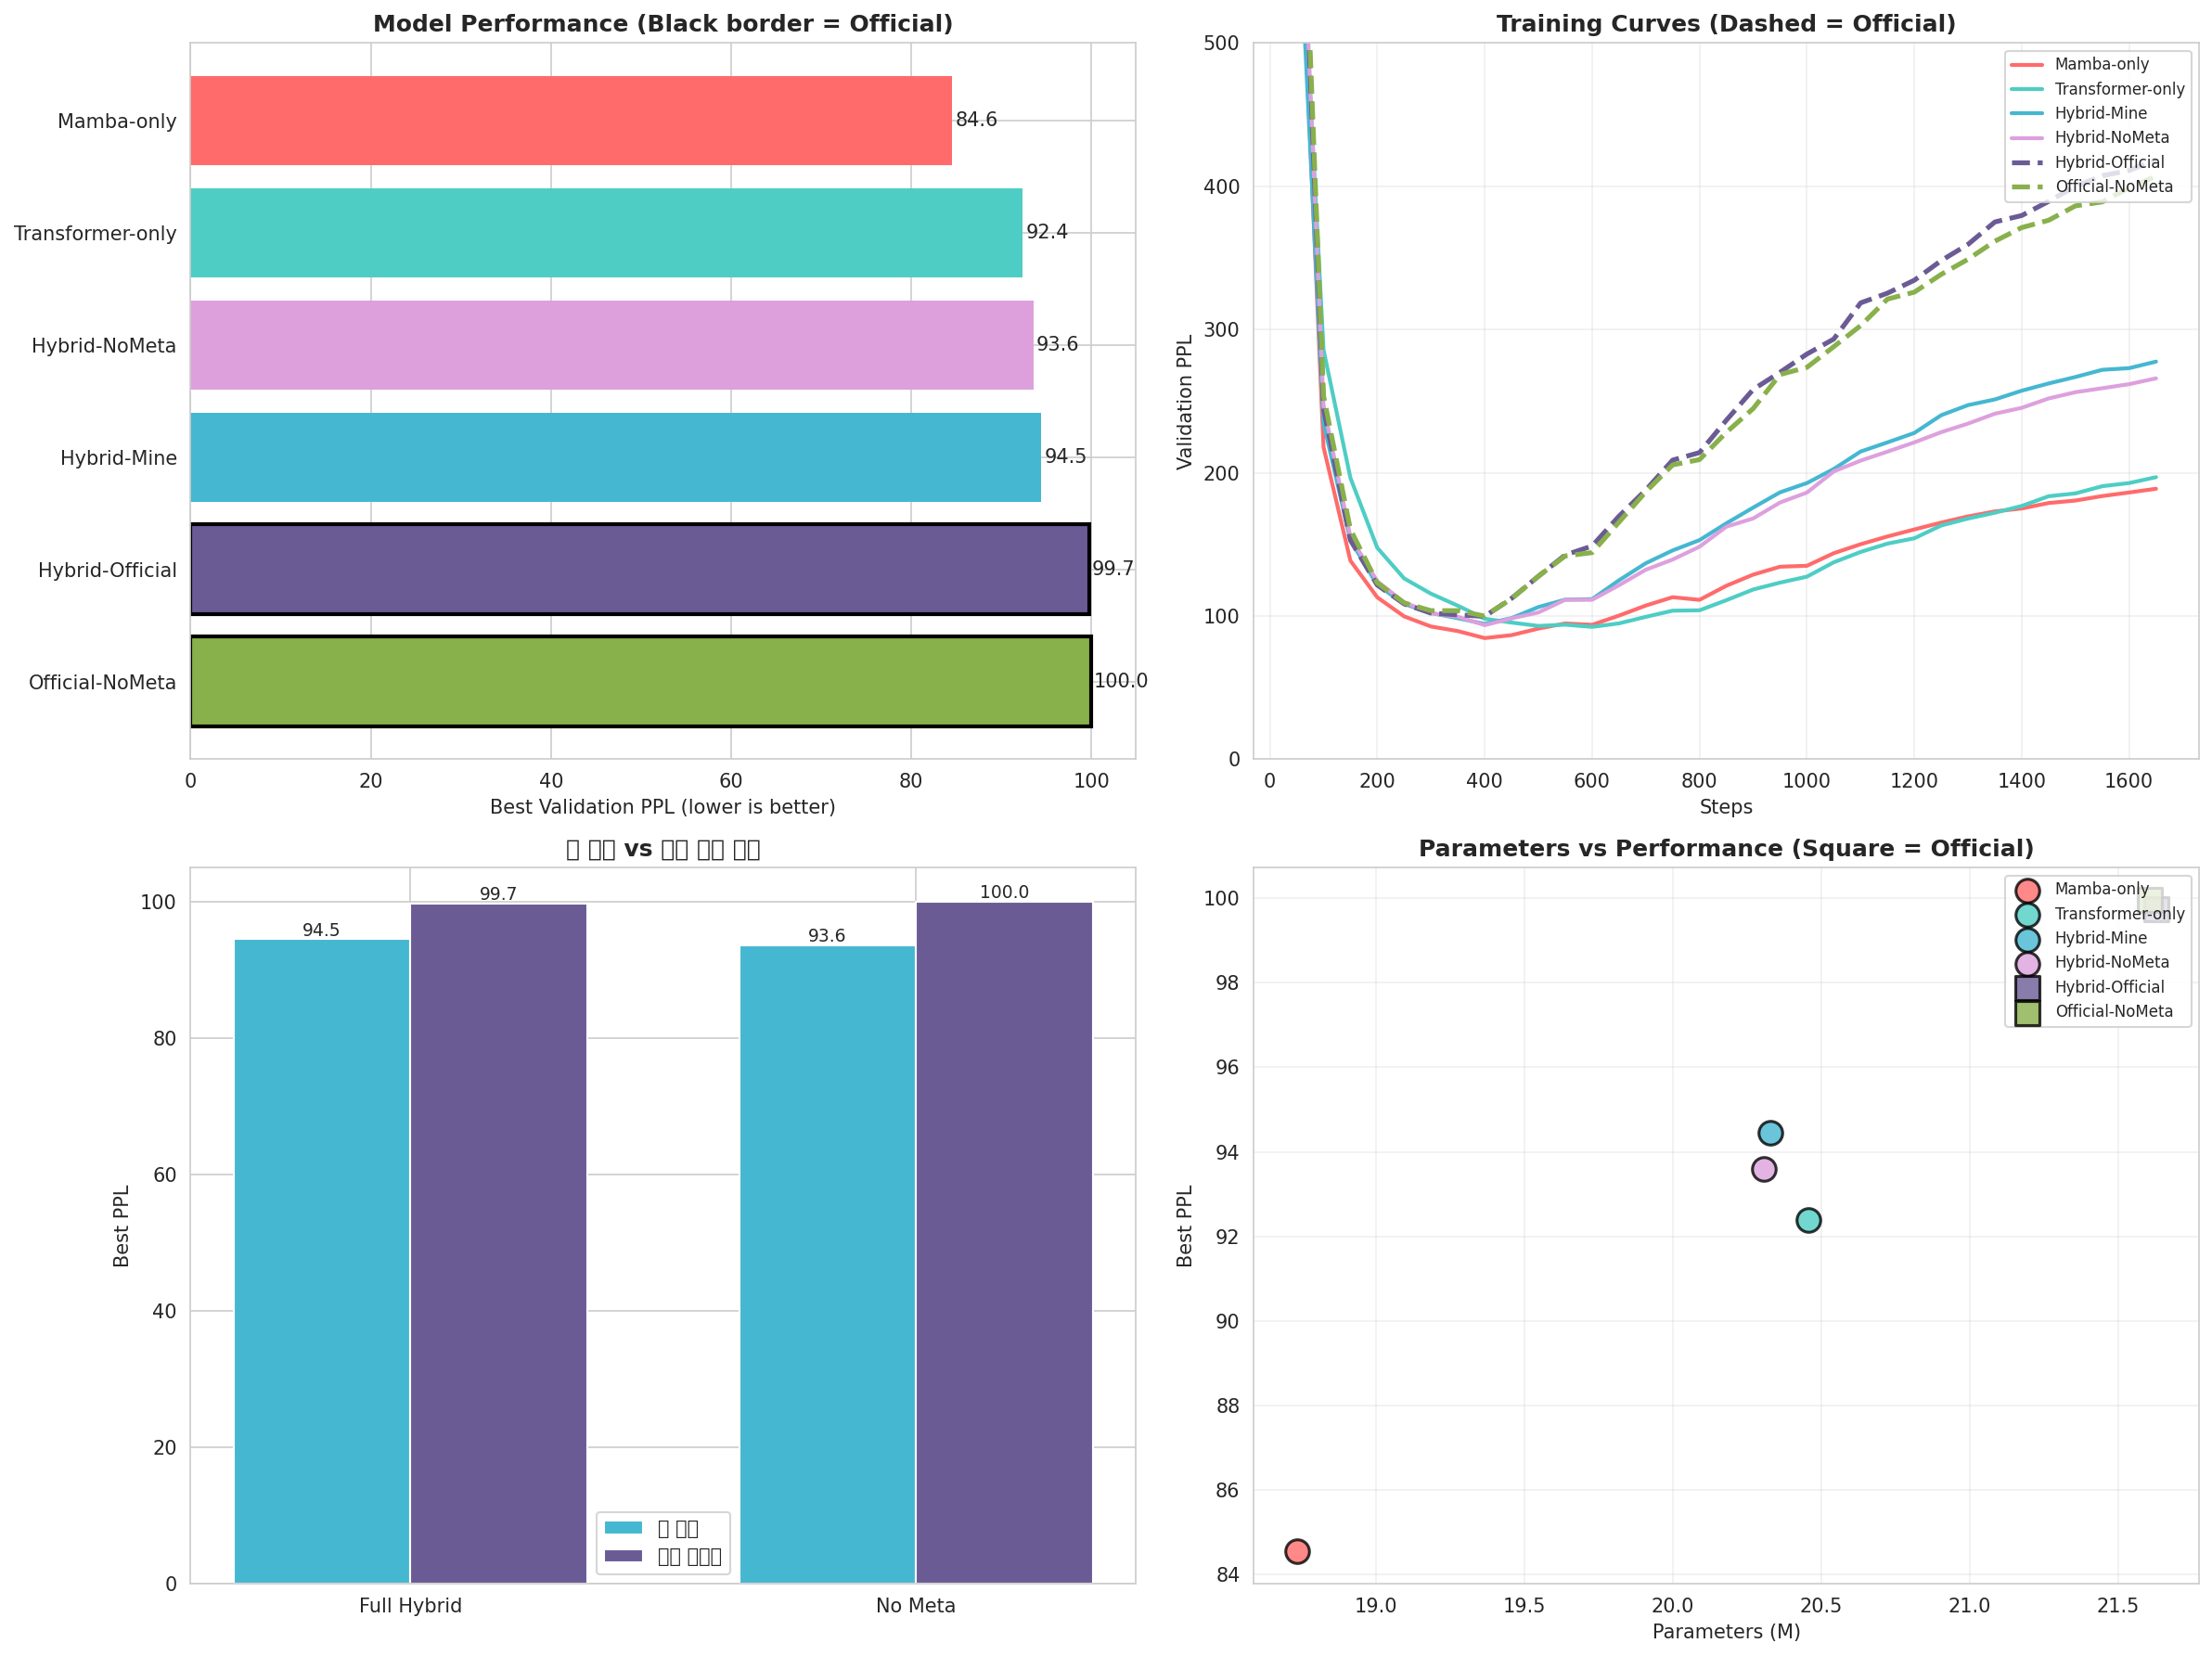

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 색상 맵 (내 구현: 따뜻한 색, 공식 구현: 차가운 색)
colors = {
    # 내 구현
    'Mamba-only': '#FF6B6B',
    'Transformer-only': '#4ECDC4',
    'Hybrid-Mine': '#45B7D1',
    'Hybrid-NoMeta': '#DDA0DD',
    # 공식 구현
    'Hybrid-Official': '#6B5B95',
    'Official-NoMeta': '#88B04B',
}

# 1. PPL 비교 (구현별 구분)
ax = axes[0, 0]
bars = ax.barh(df_sorted['Model'], df_sorted['Best PPL'], 
               color=[colors.get(m, 'gray') for m in df_sorted['Model']],
               edgecolor=['black' if df_sorted[df_sorted['Model']==m]['Implementation'].values[0] == 'Official' else 'none' 
                         for m in df_sorted['Model']],
               linewidth=2)
ax.set_xlabel('Best Validation PPL (lower is better)')
ax.set_title('Model Performance (Black border = Official)', fontweight='bold')
ax.invert_yaxis()
for bar, val in zip(bars, df_sorted['Best PPL']):
    ax.text(val + 0.3, bar.get_y() + bar.get_height()/2, f'{val:.1f}', va='center')

# 2. 학습 곡선 (구현별 선 스타일)
ax = axes[0, 1]
for name, r in results.items():
    linestyle = '--' if r.get('is_official', False) else '-'
    linewidth = 2.5 if r.get('is_official', False) else 2
    ax.plot(r['history']['step'], r['history']['val_ppl'], 
            label=name, linewidth=linewidth, linestyle=linestyle,
            color=colors.get(name, 'gray'))
ax.set_xlabel('Steps')
ax.set_ylabel('Validation PPL')
ax.set_title('Training Curves (Dashed = Official)', fontweight='bold')
ax.legend(fontsize=8, loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, min(500, ax.get_ylim()[1]))

# 3. 내 구현 vs 공식 구현 직접 비교
ax = axes[1, 0]
comparison_pairs = [
    ('Hybrid-Mine', 'Hybrid-Official', 'Full Hybrid'),
    ('Hybrid-NoMeta', 'Official-NoMeta', 'No Meta'),
]
x_pos = np.arange(len(comparison_pairs))
width = 0.35

mine_ppls = []
official_ppls = []
labels = []

for mine_name, official_name, label in comparison_pairs:
    mine_ppl = results.get(mine_name, {}).get('best_ppl', 0)
    official_ppl = results.get(official_name, {}).get('best_ppl', 0)
    mine_ppls.append(mine_ppl)
    official_ppls.append(official_ppl)
    labels.append(label)

bars1 = ax.bar(x_pos - width/2, mine_ppls, width, label='내 구현', color='#45B7D1')
bars2 = ax.bar(x_pos + width/2, official_ppls, width, label='공식 스타일', color='#6B5B95')

ax.set_ylabel('Best PPL')
ax.set_title('내 구현 vs 공식 구현 비교', fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.legend()

# 값 표시
for bar, val in zip(bars1, mine_ppls):
    if val > 0:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{val:.1f}', ha='center', fontsize=9)
for bar, val in zip(bars2, official_ppls):
    if val > 0:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{val:.1f}', ha='center', fontsize=9)

# 4. Parameters vs PPL (구현별 마커)
ax = axes[1, 1]
for name in df['Model']:
    row = df[df['Model'] == name].iloc[0]
    marker = 's' if row['Implementation'] == 'Official' else 'o'
    ax.scatter(row['Params (M)'], row['Best PPL'], 
               s=150, c=colors.get(name, 'gray'), label=name, 
               alpha=0.8, edgecolors='black', marker=marker, linewidths=1.5)
ax.set_xlabel('Parameters (M)')
ax.set_ylabel('Best PPL')
ax.set_title('Parameters vs Performance (Square = Official)', fontweight='bold')
ax.legend(fontsize=8, loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/ablation_results.png', dpi=300, bbox_inches='tight')
plt.show()

---

## 5. KV Sharing 분석

In [10]:
print('=' * 70)
print('KV Sharing Structure 비교')
print('=' * 70)

# 내 구현
print('\n[내 구현: Hybrid-Mine]')
cfg_mine = experiments['Hybrid-Mine'].config
model_mine = Hymba(cfg_mine)
kv_info = model_mine.get_kv_sharing_info()
attn_info = model_mine.get_attention_pattern_info()

print(f"Total layers: {kv_info['total_layers']}")
print(f"Global layers: {attn_info['global_layers']}")
print(f"Local layers: {attn_info['local_layers']}")
print(f"KV reuse groups: {kv_info['kv_reuse_groups']}")
print(f"Producer layers: {kv_info['producer_layers']}")
print(f"Consumer layers: {kv_info['consumer_layers']}")
print(f"KV cache reduction: {kv_info['reduction']:.2f}x")

del model_mine

# 공식 구현
print('\n[공식 스타일: Hybrid-Official]')
cfg_official = experiments['Hybrid-Official'].config
model_official = HymbaOfficialModel(cfg_official)

print(f"Total layers: {cfg_official.num_hidden_layers}")
print(f"Global layers: {cfg_official.global_attn_idx}")
local_layers = [i for i in range(cfg_official.num_hidden_layers) if i not in cfg_official.global_attn_idx]
print(f"Local layers: {local_layers}")
print(f"KV reuse groups: {cfg_official.kv_reuse_group}")

# 레이어별 Global/Local 확인
print(f"\n레이어별 Attention 타입:")
for i, layer in enumerate(model_official.layers):
    is_global = layer.mamba.self_attn.is_global
    attn_type = 'Global' if is_global else 'Local (SWA)'
    print(f"  Layer {i:2d}: {attn_type}")

del model_official
torch.cuda.empty_cache()

print('\n' + '=' * 70)
print('구현 차이점 요약')
print('=' * 70)
print("""
| 구성요소 | 내 구현 | 공식 구현 스타일 |
|----------|---------|------------------|
| Projection | 분리된 Q, K, V projection | 단일 in_proj (모든 것 포함) |
| Fusion | 학습 가능한 β 가중치 | (norm(A) + norm(M)) / 2 |
| Out projection | 분리된 경로 | 단일 out_proj |
| Attention | FlexAttention 지원 | Standard attention |
""")

KV Sharing Structure 비교

[내 구현: Hybrid-Mine]
Total layers: 11
Global layers: [0, 5, 10]
Local layers: [1, 2, 3, 4, 6, 7, 8, 9]
KV reuse groups: [[1, 2], [3, 4], [6, 7], [8, 9]]
Producer layers: [0, 1, 3, 5, 6, 8, 10]
Consumer layers: [2, 4, 7, 9]
KV cache reduction: 1.57x

[공식 스타일: Hybrid-Official]
Total layers: 11
Global layers: [0, 5, 10]
Local layers: [1, 2, 3, 4, 6, 7, 8, 9]
KV reuse groups: [[1, 2], [3, 4], [6, 7], [8, 9]]

레이어별 Attention 타입:
  Layer  0: Global
  Layer  1: Local (SWA)
  Layer  2: Local (SWA)
  Layer  3: Local (SWA)
  Layer  4: Local (SWA)
  Layer  5: Global
  Layer  6: Local (SWA)
  Layer  7: Local (SWA)
  Layer  8: Local (SWA)
  Layer  9: Local (SWA)
  Layer 10: Global

구현 차이점 요약

| 구성요소 | 내 구현 | 공식 구현 스타일 |
|----------|---------|------------------|
| Projection | 분리된 Q, K, V projection | 단일 in_proj (모든 것 포함) |
| Fusion | 학습 가능한 β 가중치 | (norm(A) + norm(M)) / 2 |
| Out projection | 분리된 경로 | 단일 out_proj |
| Attention | FlexAttention 지원 | Standard attention |



---

## 6. 텍스트 생성

In [11]:
print('=' * 70)
print('텍스트 생성 비교 (학습되지 않은 초기화 모델)')
print('=' * 70)

prompts = ['ROMEO:', 'First Citizen:']

# 내 구현
print('\n' + '='*50)
print('[내 구현]')
print('='*50)
for exp_name in ['Mamba-only', 'Transformer-only', 'Hybrid-Mine']:
    cfg = experiments[exp_name].config
    model = Hymba(cfg).to(device).eval()
    
    print(f"\n{exp_name}:")
    for prompt in prompts:
        prompt_ids = torch.tensor([tokenizer.encode(prompt)]).to(device)
        with torch.no_grad():
            output = model.generate(prompt_ids, max_new_tokens=30, temperature=0.8, top_k=40)
        text = tokenizer.decode(output[0].cpu().tolist())
        print(f"  {prompt} {text[len(prompt):][:60]}...")
    
    del model
    torch.cuda.empty_cache()

# 공식 구현
print('\n' + '='*50)
print('[공식 구현 스타일]')
print('='*50)
for exp_name in ['Hybrid-Official', 'Official-NoMeta']:
    cfg = experiments[exp_name].config
    model = HymbaOfficialModel(cfg).to(device).eval()
    
    print(f"\n{exp_name}:")
    for prompt in prompts:
        prompt_ids = torch.tensor([tokenizer.encode(prompt)]).to(device)
        with torch.no_grad():
            output = model.generate(prompt_ids, max_new_tokens=30, temperature=0.8, top_k=40)
        text = tokenizer.decode(output[0].cpu().tolist())
        print(f"  {prompt} {text[len(prompt):][:60]}...")
    
    del model
    torch.cuda.empty_cache()

텍스트 생성 비교 (학습되지 않은 초기화 모델)

[내 구현]

Mamba-only:
  ROMEO: : Ġsenators Ġdoor Ġshort Here ĠBOLINGBROKE Ġviolent Ġshut Ma...
  First Citizen:  : Ġcam Ġcharity ee Ġsteel ities ar Ġgood Ġwhy Ġap Ġam Ġmour...

Transformer-only:
  ROMEO: : sed ume utation Ġbawd ilt il Ġgoes Ġmer Ġenc iff ĠWarwick ...
  First Citizen:  : Ġgain ying Ġtrial Ġtrial CAPULET CAPULET Ġconj Ġconj Ġcon...

Hybrid-Mine:
  ROMEO: : cept arn othing Ġhumbly ating ĠGod Ġaf Ġdre ĠEngland Ġfals...
  First Citizen:  : EY Ġbeggar anch IGON Ġdiss Ġque ians which Ġdiss DO Ġrigh...

[공식 구현 스타일]

Hybrid-Official:
  ROMEO: : Ġfame Ġhope Ġmanner Cl emn Thanks ment Ġoutward Ġdark Ġeve...
  First Citizen:  : uckingham tle Ġbusiness Ġscarce Ġarm emn ial Ġwoo emn Ġth...

Official-NoMeta:
  ROMEO: : G Ġneed ĠThe ning Ġtomb vere wixt Ġreasons utation Only Ġb...
  First Citizen:  : e Our ANTIGON rence Ġoracle Ġfool under Ġfire ĠM Ġone Ġpo...


---

## 7. 결론

In [12]:
print('=' * 70)
print('실험 결론')
print('=' * 70)

best_model = df.loc[df['Best PPL'].idxmin()]
print(f"\n1. 최고 성능: {best_model['Model']} ({best_model['Implementation']})")
print(f"   PPL: {best_model['Best PPL']:.2f}")
print(f"   Params: {best_model['Params (M)']:.2f}M")

# 아키텍처 비교
print(f"\n2. 아키텍처 비교 (~20M 파라미터 통일):")
for name in ['Mamba-only', 'Transformer-only', 'Hybrid-Mine', 'Hybrid-Official']:
    r = results.get(name, {})
    ppl = r.get('best_ppl', 0)
    params = r.get('params', 0) / 1e6
    impl = '공식' if r.get('is_official', False) else '내구현'
    if ppl > 0:
        print(f"   - {name}: PPL={ppl:.2f}, {params:.1f}M ({impl})")

# 내 구현 vs 공식 구현
print(f"\n3. 내 구현 vs 공식 구현 비교:")
hybrid_mine = results.get('Hybrid-Mine', {}).get('best_ppl', 0)
hybrid_official = results.get('Hybrid-Official', {}).get('best_ppl', 0)
if hybrid_mine and hybrid_official:
    diff = hybrid_official - hybrid_mine
    better = '내 구현' if diff > 0 else '공식 구현'
    print(f"   - Hybrid-Mine: {hybrid_mine:.2f}")
    print(f"   - Hybrid-Official: {hybrid_official:.2f}")
    print(f"   - 차이: {abs(diff):.2f} ({better}이 더 좋음)")

# Meta Tokens Ablation
print(f"\n4. Meta Tokens Ablation:")
hybrid_nometa = results.get('Hybrid-NoMeta', {}).get('best_ppl', 0)
official_nometa = results.get('Official-NoMeta', {}).get('best_ppl', 0)
if hybrid_mine and hybrid_nometa:
    delta = hybrid_nometa - hybrid_mine
    effect = '개선' if delta < 0 else '악화'
    print(f"   - 내 구현: Meta 제거시 {delta:+.2f} PPL ({effect})")
if hybrid_official and official_nometa:
    delta = official_nometa - hybrid_official
    effect = '개선' if delta < 0 else '악화'
    print(f"   - 공식 구현: Meta 제거시 {delta:+.2f} PPL ({effect})")

print("\n" + "=" * 70)
print("핵심 발견")
print("=" * 70)
print("""
1. 모델 크기 통일 (~20M):
   - 공정한 비교를 위해 모든 모델 파라미터 수를 맞춤
   - Mamba-only, Transformer-only, Hybrid 모두 비슷한 크기

2. 구현 비교:
   - 내 구현: 분리된 projection, 학습 가능한 fusion weights
   - 공식 스타일: 단일 in_proj, 단순 평균 fusion
   - 두 구현 모두 SWA + Meta tokens + KV sharing 지원

3. Sliding Window Attention (SWA):
   - Global 레이어: 전체 causal attention
   - Local 레이어: window + meta token access
   - 마스크: causal AND (in_window OR is_meta)

4. Meta Tokens 효과:
   - Attention sink 문제 해결
   - PPL 개선 여부는 데이터셋/학습 조건에 따라 다름
""")

실험 결론

1. 최고 성능: Mamba-only (Mine)
   PPL: 84.56
   Params: 18.73M

2. 아키텍처 비교 (~20M 파라미터 통일):
   - Mamba-only: PPL=84.56, 18.7M (내구현)
   - Transformer-only: PPL=92.40, 20.5M (내구현)
   - Hybrid-Mine: PPL=94.46, 20.3M (내구현)
   - Hybrid-Official: PPL=99.73, 21.6M (공식)

3. 내 구현 vs 공식 구현 비교:
   - Hybrid-Mine: 94.46
   - Hybrid-Official: 99.73
   - 차이: 5.27 (내 구현이 더 좋음)

4. Meta Tokens Ablation:
   - 내 구현: Meta 제거시 -0.87 PPL (개선)
   - 공식 구현: Meta 제거시 +0.22 PPL (악화)

핵심 발견

1. 모델 크기 통일 (~20M):
   - 공정한 비교를 위해 모든 모델 파라미터 수를 맞춤
   - Mamba-only, Transformer-only, Hybrid 모두 비슷한 크기

2. 구현 비교:
   - 내 구현: 분리된 projection, 학습 가능한 fusion weights
   - 공식 스타일: 단일 in_proj, 단순 평균 fusion
   - 두 구현 모두 SWA + Meta tokens + KV sharing 지원

3. Sliding Window Attention (SWA):
   - Global 레이어: 전체 causal attention
   - Local 레이어: window + meta token access
   - 마스크: causal AND (in_window OR is_meta)

4. Meta Tokens 효과:
   - Attention sink 문제 해결
   - PPL 개선 여부는 데이터셋/학습 조건에 따라 다름



In [13]:
df.to_csv(f'{RESULTS_DIR}/ablation_results.csv', index=False)
print(f'저장: {RESULTS_DIR}/ablation_results.csv')

저장: ./results/ablation_results.csv


---

## References

1. **Hymba Paper**: Dong, X., et al. "Hymba: A Hybrid-head Architecture for Small Language Models." arXiv:2411.13676 (2024). [ICLR 2025]

2. **Official Implementation**: https://github.com/NVlabs/hymba

3. **HuggingFace Model**: https://huggingface.co/nvidia/Hymba-1.5B-Base

---